<div align='left' style="width:800px;height:120px;overflow:hidden;">
<img align='left' style='display: block;height: 100%' src='imgs/insts.png' alt='logos' title='logos'/>
</div>

# Evolutionary Multi-Objective Optimization

## [Luis Martí](http://lmarti.com)
####  Co-Head of RIO Group - [Universidade Federal Fluminense](http://www.uff.br).
####  [INRIA-Saclay](http://inria.fr) / LRI / Université Paris-Saclay.
<br>
#### JupyterDayPhilly - Byrn Mawr College, May 19th, 2017.

# Preliminaries

* This tutorial is  _programmed_ as a [Jupyter](http://jupyter.org)/[IPython](https://ipython.org/) notebook.
* See the `requirements.txt` file for a list of required libraries.
* **Feel free to try them and experiment on your own by running the notebook.**

* If you are using [nbviewer](http://nbviewer.jupyter.org) you can change to slides mode by clicking on the icon:

<br/>
<div class="container-fluid">
  <div class="row">
      <div class="col-md-2"><span/></div>
      <div class="col-md-8">
      <div class='well well-sm'>
              <img src='figs/view-as-slides.png'/>
      </div>
      </div>
      <div class="col-md-2" align='center'><span/></div>
  </div>
</div>

# Context
* Real-world problems that involve the optimization of *more than one objective* at the same time.
* Actually, those with *many* objectives.
* Evolutionary approaches to the problems.

$\newcommand{\set}[1]{\mathcal{#1}}\renewcommand{\vec}[1]{\boldsymbol{#1}}$

# In this talk
* Multi-objective optimization problems (MOPs).
* Multi-objective evolutionary algorithms (MOEAs/EMOAs).
* Performance assessment and experimentation.

In [1]:
import time, array, random, copy, math, six, itertools
import numpy as np
import pandas as pd

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
from matplotlib.path import Path
from matplotlib import animation, patches
from IPython.display import HTML
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('talk')

In [4]:
markers = ['o', '^', 's', 'D', 'v', 'h', 'p']

In [5]:
# tikzmagic extesion for figures - https://github.com/mkrphys/ipython-tikzmagic
%load_ext tikzmagic

# Multi-Objective Optimization
<br>
<div class="container-fluid">
  <div class="row">
      <div class="col-md-5">
      <div class='well well-sm'>
              <img src='https://imgs.xkcd.com/comics/fuck_grapefruit.png' align='center'/>
              <span><small>taken from http://xkcd.com/388/.</small></span>
      </div>
      </div>
      <div class="col-md-7">
          <ul>
          <li> How we handle multiple -and conflictive- objectives? </li>
          <li> It is **"easy"**: we do it all the time.</li>
          <li> Artificial intelligence is to make problems that are **easy** for humans but **hard** for computers also **easy** for computers.</li>
          <li> That is, solving NP-hard/complete problems in polynomial time.</li>
          </ul>
      </div>
  </div>
</div>


# How do you buy a car?

## Buying a car - *the computer scientist way*

1. Get the specs of all cars available in the market.
* Disregard those that do not meet our requirements or constraints.
* Search for suitable alternatives.
* Make a decision, according to our interests, of what car is the best.

## Let's do it!

## Gathering the data

* The French government keeps track  of the pollution levels of new cars sold every year (http://carlabelling.ademe.fr/).
* `pandas` is great for handling tabular data in Python. 

In [6]:
car_data = pd.read_csv('data/vehicules-commercialises.csv.gz', sep=';')

What data have we have?

In [7]:
car_data.head(3)

,Marque,Modèle dossier,Modèle commercial,Désignation commerciale,CNIT,Type Variante Version (TVV),Carburant,Hybride,Puissance administrative,Puissance maximale,...,HC,NOx,HC+NOx,Particules,Masse vide euro min,Masse vide euro max,Champ v9,Année,Carrosserie,Gamme
0,MERCEDES,SPRINTER 311 CDI 37,SPRINTER 311 CDI 37,SPRINTER 311 CDI 37,MMB73I3BXS17,NaN,Diesel,NaN,9.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,NaN,NaN
1,MERCEDES,SPRINTER 311 CDI 43,SPRINTER 311 CDI 43,SPRINTER 311 CDI 43,MMB73I3BYP75,NaN,Diesel,NaN,9.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,NaN,NaN
2,MERCEDES,SPRINTER 311 CDI 43 L,SPRINTER 311 CDI 43 L,SPRINTER 311 CDI 43 L,MMB73I3BYR37,NaN,Diesel,NaN,8.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,NaN,NaN


## Filtering cars following our constraints

We are interested in cars sold the most recent year in the dataset (in this case, 2015). Let's do that in a "computer scientist" way:

In [8]:
last_year = sorted(car_data.Année)[-1]

In [9]:
last_year

2015

In [10]:
car_data = car_data[car_data.Année == last_year]

We are also interested in gasoline cars (*essence* in French)

In [11]:
car_data = car_data[car_data.Carburant == 'Essence']

## Visualizing data

**Suppose:** We want to buy cars with high fuel efficiency and as powerful as possible.

In [12]:
def cars_plot(df, group_by):
    # ['Puissance maximale', 'Consommation mixte', 'Marque'])
    df = df.drop_duplicates()
    max_colors = 7
    fig, ax = plt.subplots(figsize=(6, 6))
    colors = seaborn.color_palette('Set1', max_colors)
    for i, (maker, group) in enumerate(df.groupby(group_by)):
        ax.plot(group['Puissance maximale'], group['Consommation mixte'],
                marker=markers[i // max_colors], color=colors[i % max_colors],
                linestyle='', ms=5.5, alpha=0.74, label=maker, markeredgecolor='k', markeredgewidth=0.25)
    plt.legend(ncol=2, numpoints=1, bbox_to_anchor=(
        1., 1.), fontsize=11, frameon=True)
    plt.xlabel('Maximum power ($\mathrm{kW}$)')
    plt.ylabel('Consumption ($\ell/100\,\mathrm{km}$)')
    plt.title('New cars sold in France in {0}'.format(last_year))
    plt.tight_layout()

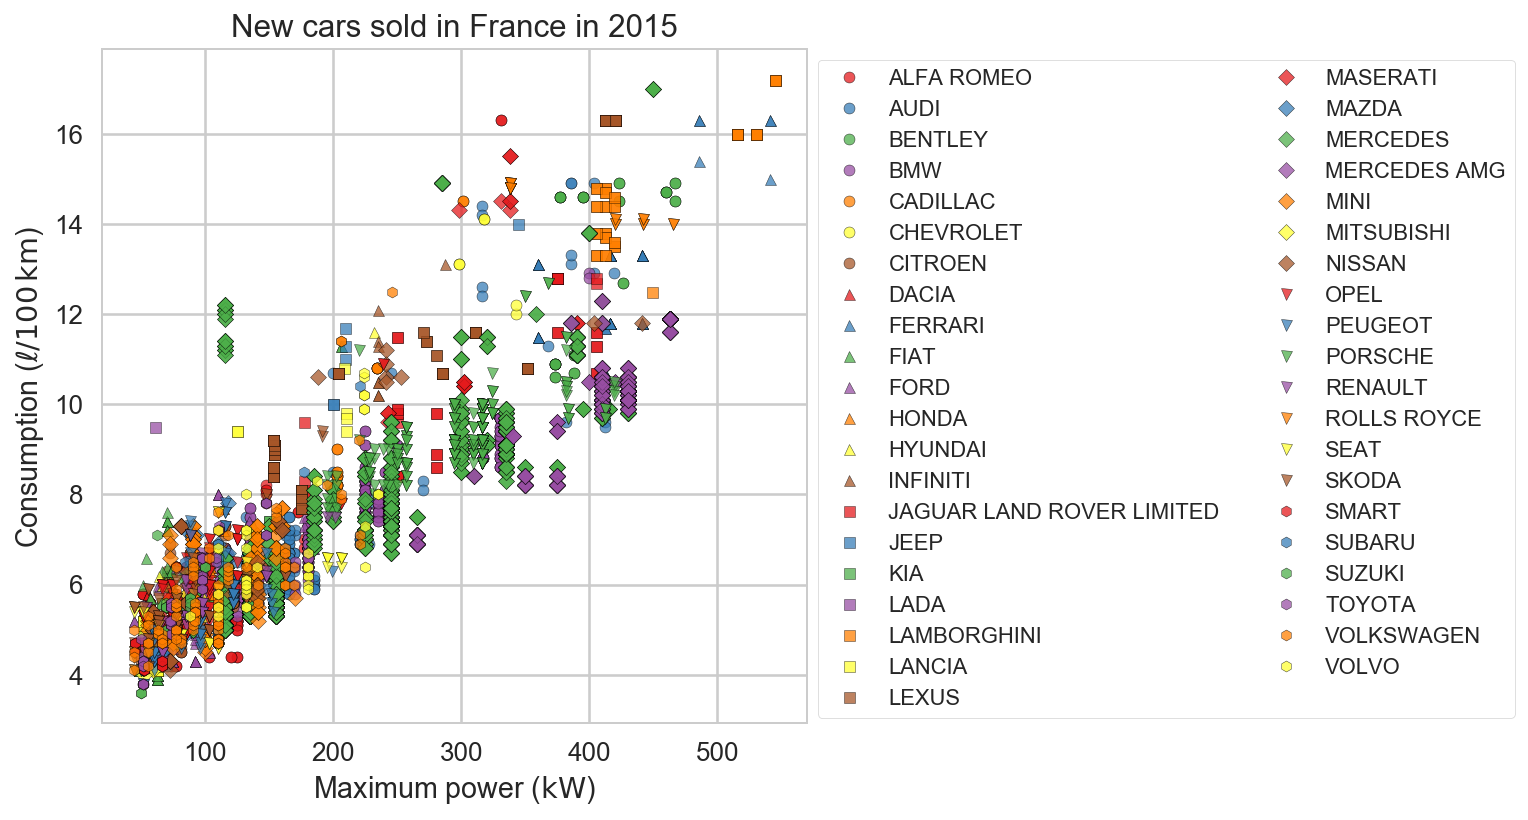

In [13]:
cars_plot(car_data, 'Marque')

# [Multi-objective optimization](http://en.wikipedia.org/wiki/Multi-objective_optimization)

* Most -*if not all*- optimization problems involve more than one objective function to be optimized simultaneously.
* Sometimes those other objectives are converted to constraints or fixed to default values, but they are still there.
* Multi-objective optimization has been applied in [many fields of science](http://en.wikipedia.org/wiki/Multi-objective_optimization#Examples_of_multi-objective_optimization_applications) where optimal decisions need to be taken in the presence of trade-offs between two or more conflicting objectives.

## Multi-objective optimization problem (MOP)

$$
\begin{array}{rl}
\text{minimize}             & \vec{F}(\vec{x})=\left\langle f_1(\vec{x}),\ldots,f_M(\vec{x})\right\rangle\,,\\ 
\text{subject to} & c_1(\vec{x}),\ldots,c_C(\vec{x})\le 0\,,\\
							  & d_1(\vec{x}),\ldots,d_D(\vec{x})= 0\,,\\
& \text{with}\ \vec{x}\in\mathcal{D}\,,
\end{array}
$$

* $\mathcal{D}$ is known as the *decision set* or *search set*.
* functions $f_1(\vec{x}),\ldots,f_M(\vec{x})$ are the *objective functions*.
* Image set, $\mathcal{O}$, result of the projection of $\mathcal{D}$ via $f_1(\vec{x}),\ldots,f_M(\vec{x})$ is called *objective set* ($\vec{F}:\mathcal{D}\rightarrow\mathcal{O}$).
* $c_1(\vec{x}),\ldots,c_C(\vec{x})\le 0$ and $d_1(\vec{x}),\ldots,d_D(\vec{x})= 0$  express the constraints imposed on the values of $\vec{x}$.

*Note 1:* In case you are -still- wondering, a maximization problem can be posed as the minimization one: $\min\ -\vec{F}(\vec{x})$.

*Note 2:* If $M=1$ the problem reduces to a single-objective optimization problem. 

## Example: A two variables and two objectives MOP
<br/>
<div class="container-fluid">
  <div class="row">
      <div class="col-md-2"><span/></div>
      <div class="col-md-8">
      <div class='well well-sm'>
              <img src='imgs/mop-2d.jpg'/>
      </div>
      </div>
      <div class="col-md-2" align='center'><span/></div>
  </div>
</div>

## MOP optimal solutions

Usually, there is not a unique solution that minimizes all objective functions simultaneously, but, instead, a set of equally good *trade-off* solutions.

**Optimality** can be defined in terms of the [*Pareto dominance*](https://en.wikipedia.org/wiki/Pareto_efficiency) relation: 
* having $\vec{x},\vec{y}\in\mathcal{D}$, $\vec{x}$ is said to ***dominate*** $\vec{y}$ (expressed as $\vec{x}\preccurlyeq\vec{y}$) iff $\forall f_j$, $f_j(\vec{x})\leq f_j(\vec{y})$ and $\exists f_i$ such that $f_i(\vec{x})< f_i(\vec{y})$.
* Having the set $\mathcal{A}$. $\mathcal{A}^\ast$, the ***non-dominated subset*** of $\mathcal{A}$, is defined as

$$
\mathcal{A}^\ast=\left\{ \vec{x}\in\mathcal{A} \left|\not\exists\vec{y}\in\mathcal{A}:\vec{y}\preccurlyeq\vec{x}\right.\right\}.
$$

* The **Pareto-optimal set**, $\mathcal{D}^{\ast}$ -the subset of non-dominated elements of $\mathcal{D}$- is the solution of the problem. 

* It is also known as the *efficient set*.
* It consists of solutions that cannot be improved in any of the objectives without degrading at least one of the other objectives.
* Its image in objective set is called the *Pareto-optimal front*, $\mathcal{O}^\ast$.
* Evolutionary algorithms generally yield a set of non-dominated solutions, $\mathcal{P}^\ast$, that approximates $\mathcal{D}^{\ast}$.

## Visualizing the Pareto dominance relation

* To start, let's have a visual example of the Pareto dominance relationship in action.
* In this notebook we will deal with two-objective problems in order to simplify visualization. 

In [14]:
from deap import algorithms, base, benchmarks, tools, creator

Defining class of two-objective minimization individuals.

In [15]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual2Obj", array.array, typecode='d', 
               fitness=creator.FitnessMin)

### An illustrative MOP: Dent

$$
\begin{array}{rl}
\text{minimize} & f_1(\vec{x}),\,f_2(\vec{x}) \\
\text{such that} & f_1(\vec{x}) = \frac{1}{2}\left( \sqrt{1 + (x_1 + x_2)^2} \sqrt{1 + (x_1 - x_2)^2} + x_1 -x_2\right) + d\,,\\
 & f_2(\vec{x}) = \frac{1}{2}\left( \sqrt{1 + (x_1 + x_2)^2} \sqrt{1 + (x_1 - x_2)^2} - x_1 -x_2\right) + d\,,\\
\text{with}& d = \lambda e^{-\left(x_1-x_2\right)^2}\ (\text{generally }\lambda=0.85) \text{ and } \vec{x}\in \left[-1.5,1.5\right]^2\,.
\end{array}
$$

Implementing the Dent problem

In [16]:
def dent(individual, lbda = 0.85):
    d  = lbda * math.exp(-(individual[0] - individual[1]) ** 2)  
    f1 = 0.5 * (math.sqrt(1 + (individual[0] + individual[1]) ** 2) + \
                math.sqrt(1 + (individual[0] - individual[1]) ** 2) + \
                individual[0] - individual[1]) + d
    f2 = 0.5 * (math.sqrt(1 + (individual[0] + individual[1]) ** 2) + \
                math.sqrt(1 + (individual[0] - individual[1]) ** 2) - \
                individual[0] + individual[1]) + d
    return f1, f2

### Preparing a DEAP `toolbox` with Dent.

DEAP toolboxes contain the configuration of the algorithm, the operators that are applied to individuals and much more.

In [17]:
toolbox = base.Toolbox()

In [18]:
N_DIM = 2 # dimensions of x
BOUND_LOW, BOUND_UP = -1.5, 1.5 # bounds for each dimension

Specify that we will be using the `dent()` function for evaluating our solutions.

In [19]:
toolbox.register('evaluate', dent)

Defining attributes, individuals and population.

In [20]:
def uniform(bound_low, bound_up, size=None):
    'Initialization of individuals.'
    return [random.uniform(a, b) for a, b in zip([bound_low] * size, [bound_up] * size)]

In [21]:
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, N_DIM)
toolbox.register("individual", tools.initIterate,
                 creator.Individual2Obj, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual)

Creating an example population distributed as a mesh.

In [22]:
NUM_SAMPLES = 40
limits = [np.arange(BOUND_LOW, BOUND_UP, (BOUND_UP -
                                          BOUND_LOW) / NUM_SAMPLES)] * N_DIM
sample_x = np.meshgrid(*limits)

In [23]:
flat = []
for i in range(len(sample_x)):
    x_i = sample_x[i]
    flat.append(x_i.reshape(NUM_SAMPLES**N_DIM))

In [24]:
example_pop = toolbox.population(n=NUM_SAMPLES**N_DIM)

In [25]:
for i, ind in enumerate(example_pop):
    for j in range(len(flat)):
        ind[j] = flat[j][i]

In [26]:
fitnesses = toolbox.map(toolbox.evaluate, example_pop)
for ind, fit in zip(example_pop, fitnesses):
    ind.fitness.values = fit

## Visualizing Dent 

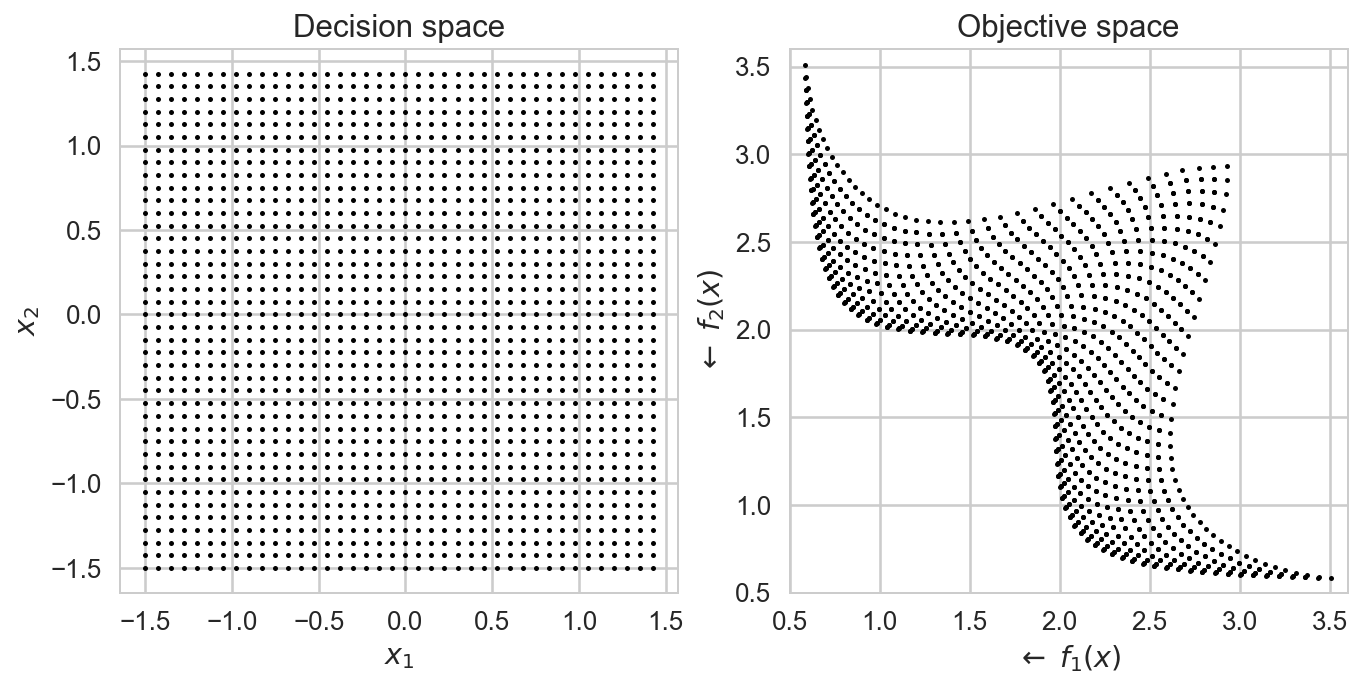

In [27]:
plt.figure(figsize=(11,5));plt.subplot(1,2,1)
for ind in example_pop: plt.plot(ind[0], ind[1], 'k.', ms=5)
plt.xlabel('$x_1$');plt.ylabel('$x_2$');plt.title('Decision space');
plt.subplot(1,2,2)
for ind in example_pop: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=5)
plt.xlabel('$\leftarrow$ $f_1(x)$');plt.ylabel('$\leftarrow$ $f_2(x)$');
plt.xlim((0.5,3.6));plt.ylim((0.5,3.6)); plt.title('Objective space');

We can now create `a_given_individual` in $(0.5,0.5)$.

In [28]:
a_given_individual = toolbox.population(n=1)[0]
a_given_individual[0] = 0.5
a_given_individual[1] = 0.5

...and evaluate it.

In [29]:
a_given_individual.fitness.values = toolbox.evaluate(a_given_individual)

Implementing the Pareto dominance relation between two individuals.

In [30]:
def pareto_dominance(ind1, ind2):
    'Returns `True` if `ind1` dominates `ind2` - assumes min. problem.'
    extrictly_better = False
    for obj1 in ind1.fitness.values:
        for obj2 in ind2.fitness.values:
            if obj1 > obj2:
                return False
            if not extrictly_better and obj1 < obj2:
                extrictly_better = True
    return extrictly_better

*Note:* Bear in mind that DEAP implements a Pareto dominance relation that probably is more efficient than this implementation. The previous function would be something like:

In [31]:
def efficient_pareto_dominance(ind1, ind2):
    return tools.emo.isDominated(ind1.fitness.values, ind2.fitness.values)

Let's compute the set of individuals that are `dominated` by `a_given_individual`, the ones that dominate it (`dominating`) and the remaining (`incomparable`) ones.

In [32]:
dominated = [ind for ind in example_pop
             if pareto_dominance(a_given_individual, ind)]

In [33]:
dominating = [ind for ind in example_pop 
              if pareto_dominance(ind, a_given_individual)]

In [34]:
incomparable = [ind for ind in example_pop 
          if not ind in dominated and not ind in dominating]

In [35]:
def plot_dent():
    'Plots the points in decision and objective spaces.'
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    for ind in dominating: 
        plt.plot(ind[0], ind[1], 'r.', markeredgecolor='k', markeredgewidth=0.5)
    for ind in dominated: 
        plt.plot(ind[0], ind[1], 'g.', markeredgecolor='k', markeredgewidth=0.5)
    for ind in incomparable: 
        plt.plot(ind[0], ind[1], 'k.', ms=5)
    plt.plot(a_given_individual[0], a_given_individual[1], marker='D',
             ms=11, markeredgecolor='b', markerfacecolor='lightblue', markeredgewidth=2.5)
    plt.xlabel('$x_1$'); plt.ylabel('$x_2$'); plt.title('Decision space')
    
    plt.subplot(1,2,2)
    for ind in dominating: 
        plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'ro', alpha=0.74, 
                 ms=5, markeredgecolor='k', markeredgewidth=0.5)
    for ind in dominated: 
        plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'go', alpha=0.74, 
                 ms=5, markeredgecolor='k', markeredgewidth=0.5)
    for ind in incomparable: 
        plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', alpha=0.74, ms=5)
    plt.plot(a_given_individual.fitness.values[0], a_given_individual.fitness.values[1], marker='D',
             ms=11, markeredgecolor='b', markerfacecolor='lightblue', markeredgewidth=2.5)
    plt.xlabel('$f_1(\mathbf{x})$'); plt.ylabel('$f_2(\mathbf{x})$')
    plt.xlim((0.5,3.6)); plt.ylim((0.5,3.6)); plt.title('Objective space')
    plt.tight_layout()

Having `a_given_individual` ($\color{blue}{\diamondsuit}$) we can plot the points that are $\color{green}{\text{dominated by it}}$ ($\color{green}{\bullet}$), those that $\color{red}{\text{dominate it}}$ ($\color{red}{\bullet}$) and those that are incomparable ($\color{gray}{\bullet}$).

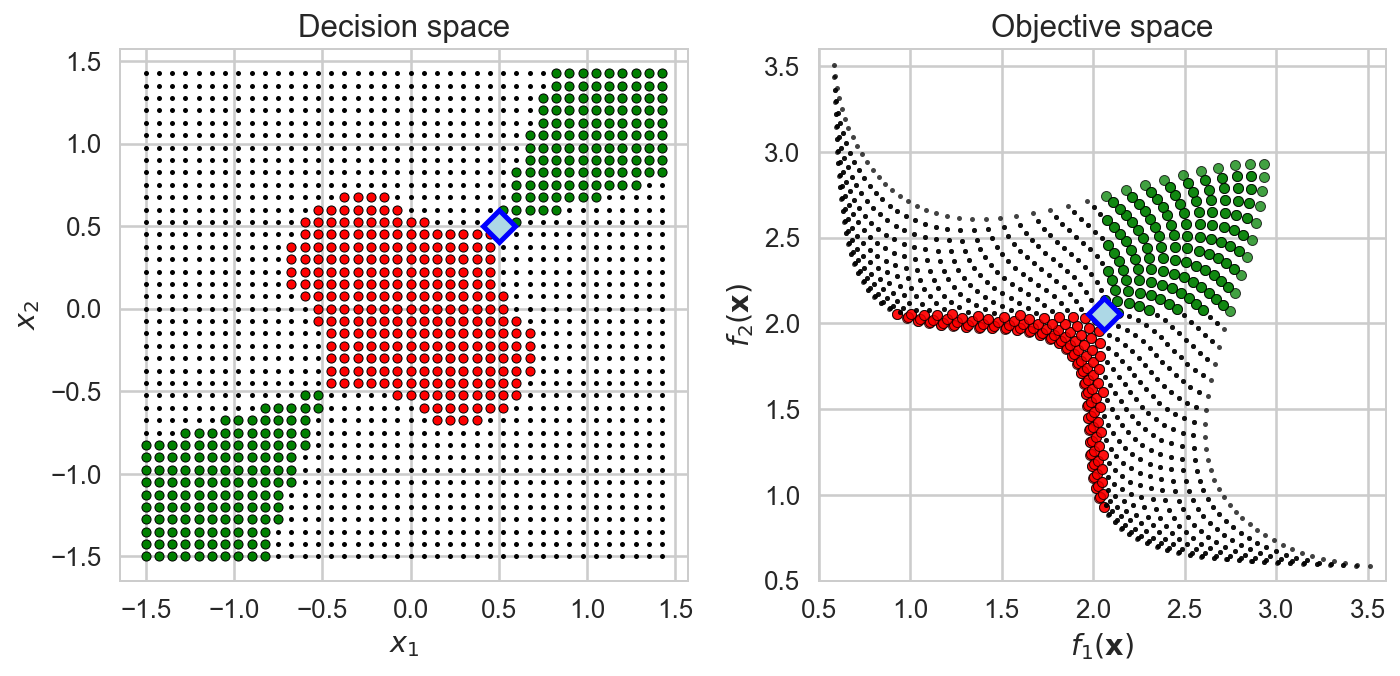

In [36]:
plot_dent()

Obtaining the non-dominated front using DEAP's `sortNondominated()` function that returns a list of consecutive non-dominated fronts.

In [37]:
non_dom = tools.sortNondominated(example_pop, k=len(example_pop), first_front_only=True)[0]

In [38]:
def non_dom_plot():
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    for ind in example_pop:
        plt.plot(ind[0], ind[1], 'k.', ms=5)
    for ind in non_dom:
        plt.plot(ind[0], ind[1], 'bo', alpha=0.74, ms=5,
                 markeredgecolor='k', markeredgewidth=0.5)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title('Decision space')
    plt.subplot(1, 2, 2)
    for ind in example_pop:
        plt.plot(ind.fitness.values[0],
                 ind.fitness.values[1], 'k.', ms=5, alpha=0.5)
    for ind in non_dom:
        plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'bo',
                 alpha=0.74, ms=5, markeredgecolor='k', markeredgewidth=0.25)
    plt.xlabel('$f_1(x)$')
    plt.ylabel('$f_2(x)$')
    plt.title('Objective space')
    plt.tight_layout()

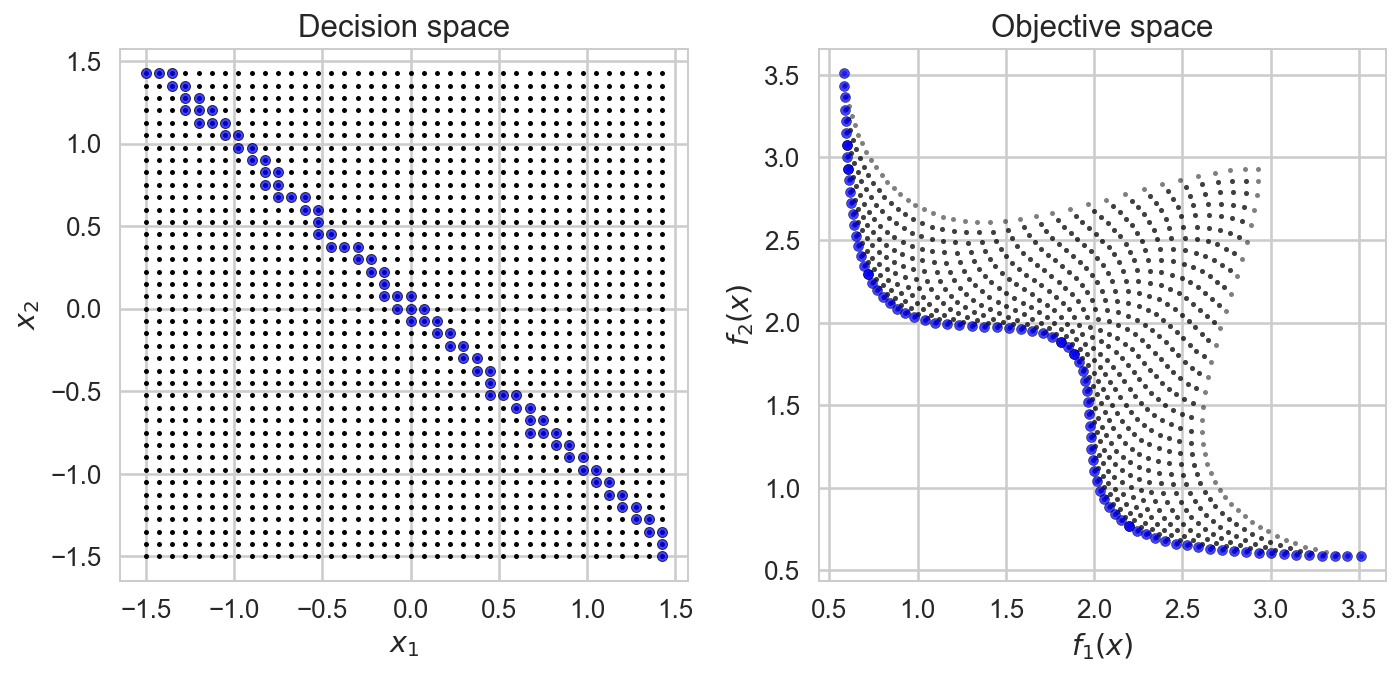

In [39]:
non_dom_plot()

In [40]:
colors = itertools.cycle(seaborn.color_palette('Set2', 10))

In [41]:
fronts = tools.sortNondominated(example_pop, k=len(example_pop))

In [42]:
def animate(frame_index):
    ax.clear()
    for ind in example_pop: 
        ax.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=5, alpha=0.5)
    inds_obj = np.array(sorted([ind.fitness.values for ind in fronts[frame_index]], key=lambda obj:obj[0]))
    ax.plot(inds_obj[:,0], inds_obj[:,1], marker='o', color=next(colors), alpha=1, 
            linestyle='-', linewidth=6, ms=6, markeredgecolor='k', markeredgewidth=0.5) 
    ax.set_title('Front '+str(frame_index+1))
    ax.set_xlabel('$f_1(\mathbf{x})$');ax.set_ylabel('$f_2(\mathbf{x})$')
    return []

In [43]:
fig = plt.figure(figsize=(6,6.5))
ax = fig.gca()
anim = animation.FuncAnimation(fig, animate, 
                               frames=len(fronts), interval=250, 
                               blit=True)
plt.close()

## Extracting consecutive non-dominated fronts

In [44]:
# HTML(anim.to_html5_video())

In [109]:
HTML("""<video width="640" height="480" controls>
<source src="Pareto-fronts.mp4" type="video/mp4">
</video>""")

# Remember our cars example?

We can determine the non-dominated front of our cars.

* We can reuse most of the stuff we have just coded the Dent problem.
* The fitness must change as we want to minimize fuel consumption and maximize power.

In [45]:
creator.create("FitnessCars", base.Fitness, weights=(-1.0, 1.0))
creator.create("Individual2ObjCars", array.array,
               typecode='d', fitness=creator.FitnessCars)

Updating the `toolbox`.

In [46]:
toolbox.register("individual", tools.initIterate,
                 creator.Individual2ObjCars, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual)

In [47]:
car_pop = toolbox.population(n=len(car_data))

In [48]:
for i, (_, data) in enumerate(car_data.iterrows()):
    car_pop[i].fitness.values = (
        data['Consommation mixte'], data['Puissance maximale'])
    car_pop[i].label = data['Marque'] + ' - ' + data['Modèle commercial']

In [49]:
non_dom = tools.sortNondominated(car_pop, k=len(car_pop), 
                                 first_front_only=True)[0]

Non-dominated cars as a `pandas.DataFrame`.

In [50]:
df = pd.DataFrame(columns=('Brand_Model', 'Consommation mixte', 
                           'Puissance maximale'))

In [51]:
for i, ind in enumerate(non_dom):
    df.loc[i] = (ind.label, ind.fitness.values[0], ind.fitness.values[1])

Peeking at results

In [52]:
df.head()

,Brand_Model,Consommation mixte,Puissance maximale
0,BENTLEY - CONTINENTAL,14.5,467.0
1,BENTLEY - CONTINENTAL,14.5,467.0
2,ALFA ROMEO - MITO,4.4,125.0
3,ALFA ROMEO - MITO,4.4,125.0
4,FIAT - 500,3.9,62.5


Plotting the non-dominated cars.

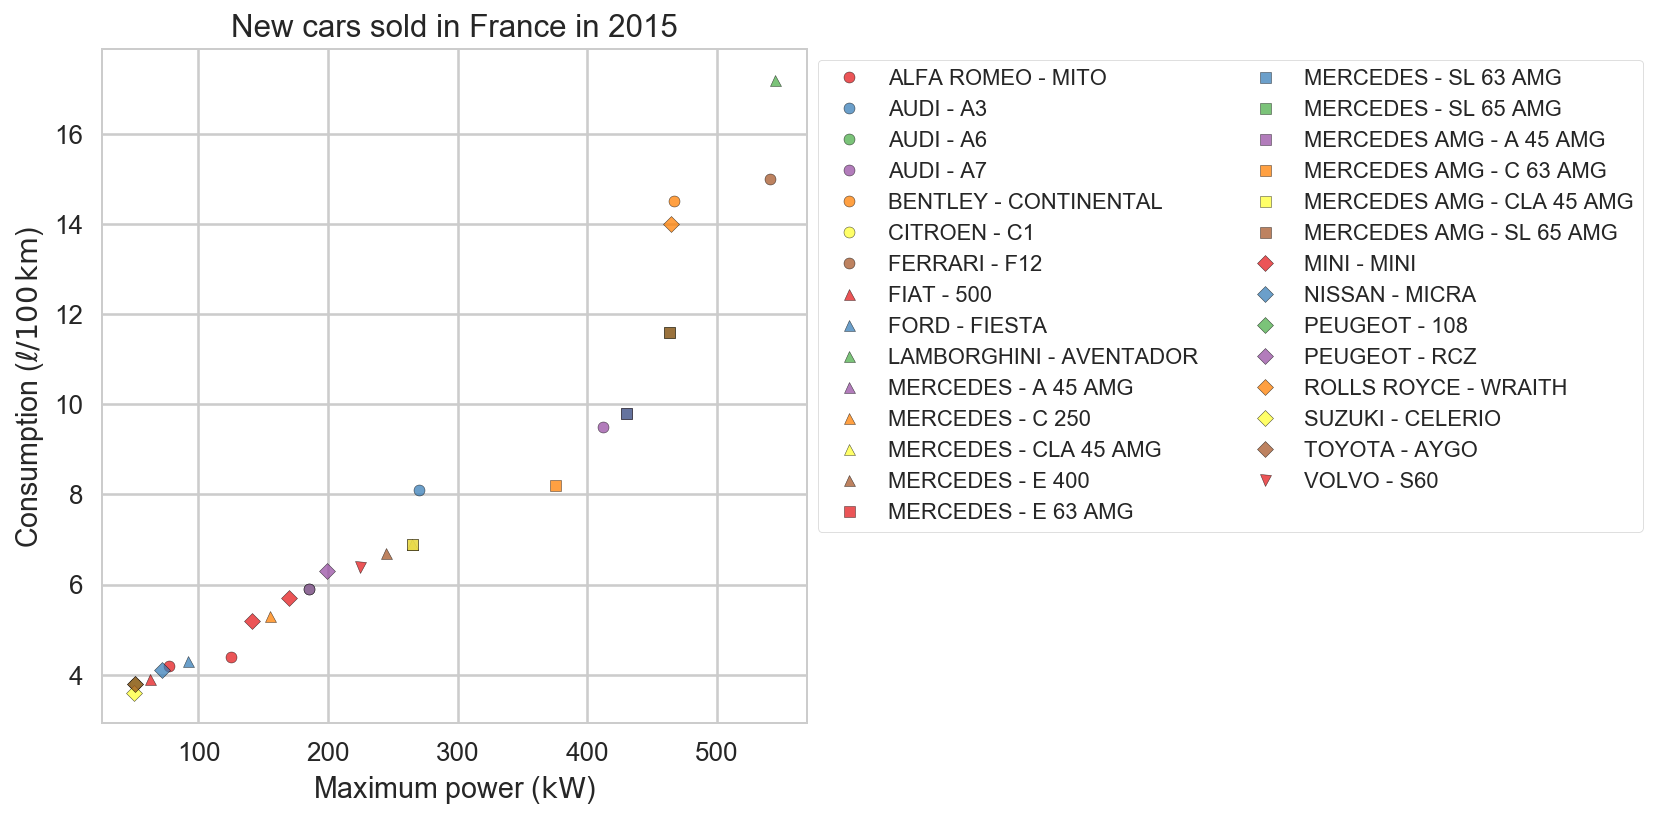

In [53]:
cars_plot(df, 'Brand_Model')

### Looks like we have solved the problem... but we haven't!
* How fine-grained the mesh should be?
* Doing this exhaustive mapping of the search space becomes computationally inviable as the number of dimensions grow.
* MOPs, in the general case are NP-hard problems.
* Brute force is never the solution in just-a-little-more-complex cases.
* We need an *strategy* for exploring the search space.

### Forward pointer: 
* Solutions in 'outer' fronts are better that those in 'deeper' ones.

An example, solving the TSP problem using brute force:
<table>
<tr><th>$n$ cities</th><th>time</th></tr>
<tr><td>10</td><td>3 secs</td></tr>
<tr><td>12</td><td>3 secs &times; 12 &times; 11 = 6.6 mins</td></tr>
<tr><td>14</td><td>6.6 mins &times; 13 &times; 14 = 20 hours</td></tr>
<tr><td>24</td><td>3 secs &times; 24! / 10! = <a href="https://www.google.com/search?q=3+seconds+*+24!+%2F+10!+in+years">16 billion years</a></td></tr></table>

_Note_: See my PhD EC course notebooks https://github.com/lmarti/evolutionary-computation-course for a notebook on solving the TSP problem using evolutionary algorithms.

## Evolutionary algorithms
<br/>
<div class="container-fluid">
  <div class="row">
      <div class="col-md-2"><span/></div>
      <div class="col-md-8">
      <div class='well well-sm'>
              <img src='imgs/moea.png'/>
      </div>
      </div>
      <div class="col-md-2" align='center'><span/></div>
  </div>
</div>

Mating selection + Variation (Offsping generation) + Enviromental selection $\implies$ global + local  parallel search features.

### The Non-dominated Sorting Genetic Algorithm (NSGA-II)

NSGA-II algorithm is one of the pillars of the EMO field.

* Deb, K., Pratap, A., Agarwal, S., Meyarivan, T., *A fast and elitist multiobjective genetic algorithm: NSGA-II*, IEEE Transactions on Evolutionary Computation, vol.6, no.2, pp.182,197, Apr 2002 doi: [10.1109/4235.996017](http://dx.doi.org/10.1109/4235.996017).

## Key element of NSGA-II

* Fitness assignment relies on the Pareto dominance relation:
    1. Rank individuals according the dominance relations established between them. 
    2. Individuals with the same domination rank are then compared using a local crowding distance.

<div class="container-fluid">
  <div class="row">
      <div class="col-md-4"><span/></div>
      <div class="col-md-4">
      <div class='well well-sm'>
              <img src='imgs/population.png'/>
      </div>
      </div>
      <div class="col-md-4" align='center'><span/></div>
  </div>
</div>

## NSGA-II fitness assigment in detail

* The first step consists in classifying the individuals in a series of categories $\mathcal{F}_1,\ldots,\mathcal{F}_L$. 
* Each of these categories store individuals that are only dominated by the elements of the previous categories,
$$
\begin{array}{rl}
	\forall \vec{x}\in\mathcal{F}_i: &\exists \vec{y}\in\mathcal{F}_{i-1} \text{ such that } \vec{y}\preccurlyeq\vec{x},\text{ and }\\ 
	                            &\not\exists\vec{z}\in \mathcal{P}_t\setminus\left( \mathcal{F}_1\cup\ldots\cup\mathcal{F}_{i-1}
	                            \right)\text{ that }\vec{z}\preccurlyeq\vec{x}\,;
\end{array}
$$
with $\mathcal{F}_1$ equal to $\mathcal{P}_t^\ast$, the set of non-dominated individuals of $\mathcal{P}_t$.

* After all individuals are ranked a local crowding distance is assigned to them. 
* The use of this distance primes individuals more isolated with respect to others. 

## Crowding distance
* For each category set $\mathcal{F}_l$, having $f_l=|\mathcal{F}_l|$,
    * for each individual $\vec{x}_i\in\mathcal{F}_l$, set $d_{i}=0$.
    * for each objective function $m=1,\ldots,M$,
        * $\mathbf{I}=\mathrm{sort}\left(\mathcal{F}_l,m\right)$ (generate index vector).
        * $d_{I_1}^{(l)}=d_{I_{f_l}}^{(l)}=\infty$. $\leftarrow$ **key element!**
        * for $i=2,\ldots,f_l-1$,
            * Update distances as,
$$
d_i = d_i + \frac{f_m\left(\vec{x}_{I_{i+1}}\right)-f_m\left(\vec{x}_{I_{i+1}}\right)} {f_m\left(\vec{x}_{I_{1}}\right)-f_m\left(\vec{x}_{I_{f_l}}\right)}$$

Here the $\mathrm{sort}\left(\mathcal{F},m\right)$ function produces an ordered index vector $\mathbf{I}$ with respect to objective function $m$. 

Sorting the population by rank and distance.

* Having the individual ranks and their local distances they are sorted using the crowded comparison operator, stated as: 
    * An individual $\vec{x}_i$ _is better than_ $\vec{x}_j$ if:
        * $\vec{x}_i$ has a better rank: $\mathrm{x}_i\in\mathcal{F}_k$, $\vec{x}_j\in\mathcal{F}_l$ and $k<l$, or;
        * if $k=l$ and $d_i>d_j$.
        
**$\rightarrow$ Now we have key element of the the non-dominated sorting GA.**

## Implementing NSGA-II

We will deal with [DTLZ3](http://www.tik.ee.ethz.ch/sop/download/supplementary/testproblems/dtlz3/), which is a more difficult test problem.

* DTLZ problems can be configured to have as many objectives as desired.
* As we want to visualize results we will stick to two objectives.
* The Pareto-optimal front of DTLZ3 lies in the first [orthant](http://en.wikipedia.org/wiki/Orthant) of a unit (radius 1) hypersphere located at the coordinate origin ($\vec{0}$).
* It has many local optima that run parallel to the global optima and render the optimization process more complicated.

<div class="container-fluid">
  <div class="row">
      <div class="col-md-3"><span/></div>
      <div class="col-md-6">
      <div class='well well-sm'>
              <img src='https://www.cs.cinvestav.mx/~emoobook/apendix-e/galeria4/dtlz3a.jpg'/>
              <span><small>From: Coello Coello, Lamont and Van Veldhuizen (2007) *Evolutionary Algorithms for Solving Multi-Objective Problems*, Second Edition. Springer [Appendix E](http://www.cs.cinvestav.mx/~emoobook/apendix-e/apendix-e.html).</small></span>
      </div>
      </div>
      <div class="col-md-3" align='center'><span/></div>
  </div>
</div>

Preparing a new `toolbox` instance with the necessary components.

In [54]:
toolbox = base.Toolbox()

Define problem domain as $\vec{x}\in\left[0,1\right]^{30}$ and a two-objective DTLZ3 instance.

In [55]:
BOUND_LOW, BOUND_UP = 0.0, 1.0
N_DIMS = 30
toolbox.register("evaluate", lambda ind: benchmarks.dtlz3(ind, 2))

Describing attributes, individuals and population and defining the selection, mating and mutation operators.

In [56]:
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, N_DIM)
toolbox.register("individual", tools.initIterate, creator.Individual2Obj, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/N_DIM)
toolbox.register("select", tools.selNSGA2)

Let's also use the `toolbox` to store other configuration parameters of the algorithm. This will show itself usefull when performing massive experiments.

In [57]:
toolbox.pop_size = 25
toolbox.max_gen = 100
toolbox.mut_prob = 0.2

## A compact GA implementation

Storing all the required information in the `toolbox` and using DEAP's `algorithms.eaMuPlusLambda` function allows us to create a very compact -albeit not a 100% exact copy of the original- implementation of NSGA-II.

In [58]:
def run_ea(toolbox, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    pop = toolbox.select(pop, len(pop))
    return algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=1-toolbox.mut_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=verbose)

# Running NSGA-II on DTLZ3

In [59]:
%time res, _ = run_ea(toolbox)

CPU times: user 331 ms, sys: 3.16 ms, total: 334 ms
Wall time: 338 ms


We can now get the Pareto fronts from the final population stored in `res`.

In [60]:
fronts = tools.emo.sortNondominated(res, len(res))

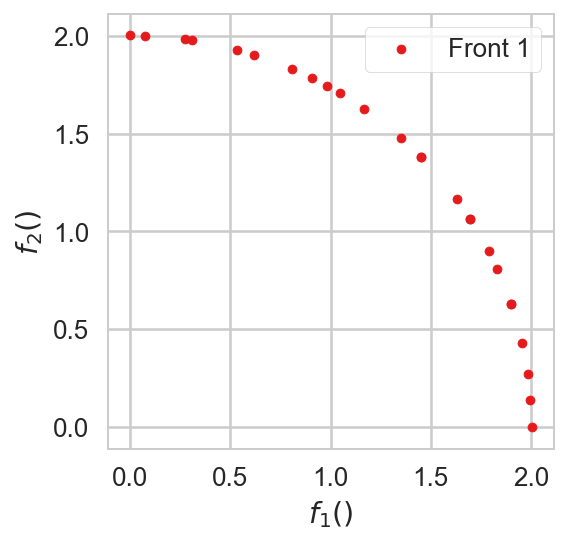

In [61]:
plot_colors = mpl.cm.Set1(np.linspace(0, 1, len(fronts)))
fig, ax = plt.subplots(1, figsize=(4,4))
for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)
    df.plot(ax=ax, kind='scatter', label='Front ' + str(i+1), 
            x=df.columns[0], y=df.columns[1], color=plot_colors[i])
plt.xlabel('$f_1()$');plt.ylabel('$f_2()$'); plt.legend(frameon=True);

## Animating the evolutionary process

* It is better to make an animated plot of the evolution as it takes place.
* We create a `stats` to store the individuals not only their objective function values.

In [62]:
stats = tools.Statistics()
stats.register("pop", copy.deepcopy)

In [63]:
%time res, logbook = run_ea(toolbox, stats=stats)

CPU times: user 434 ms, sys: 6.67 ms, total: 440 ms
Wall time: 472 ms


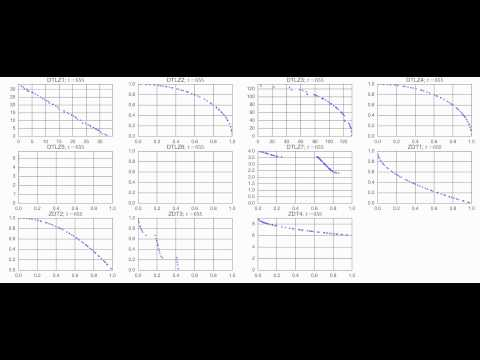

In [64]:
from IPython.display import YouTubeVideo
YouTubeVideo('8t-aWcpDH0U')

# Performance analysis and experiment design

* Watching an animation of an EMO algorithm solve a problem is certainly fun. 
* It also allows us to understand many particularities of the problem being solved.
* But, as [Carlos Coello](http://delta.cs.cinvestav.mx/~ccoello/) would say, we are *not* in an art appreciation class.
* We should follow the key concepts provided by the [scientific method](http://en.wikipedia.org/wiki/Scientific_method).
* I urge you to study the [experimental design](http://en.wikipedia.org/wiki/Design_of_experiments) topic in depth as it is an essential knowledge.

**Evolutionary algorithms are stochastic algorithms, therefore their results must be assessed by repeating experiments until you reach an statistically valid conclusion.** 

## Assessing MOEA performance

* Visual assessment: Plot the non-dominated fronts and compare them.
* Express the quality of the approximation in terms of a performance indicator:
   * Hypervolume indicator,
   * Additive/multiplicative epsilon indicator,
   * R2 indicator,
   * Inverted Generational distance indicator, etc.

# The hypervolume indicator

<div class="container-fluid">
  <div class="row">
      <div class="col-md-1"><span/></div>
      <div class="col-md-4">
      <div class='well well-sm'>
              <img src='imgs/hv.png'>
      </div>
      <div class="col-md-2"><span/></div>
      </div>
      <div class="col-md-4">
      <div class='well well-sm'>
              <img src='imgs/hv3d.png'>
      </div>
      </div>
      <div class="col-md-1"><span/></div>
  </div>
  <div class="row">
      <div class="col-md-1"><span/></div>
      <div class="col-md-10">
      <small>From Günter Rudolph's [site on the hypervolume indicator](https://ls11-www.cs.uni-dortmund.de/rudolph/hypervolume/start).</small>
      </div>
      <div class="col-md-1"><span/></div>
  </div>
</div>

## Formalization of the hypervolume

For a set of solutions $\mathcal{A}$,
$$
I_\mathrm{hyp}\left(\mathcal{A}\right) = \mathrm{volume}\left(
					\bigcup_{\forall \mathbf{a}\in\mathcal{A}}{\mathrm{hypercube}(\mathbf{a},\mathbf{r})}\right)\,.
$$

* We need a *reference point*, $\mathbf{r}$.
* Hypervolume is Pareto compliant (Fleischer, 2003): for sets $\mathcal{A}$ and $\mathcal{B}$, $\mathcal{A}\preccurlyeq\mathcal{B} \implies I_\mathrm{hyp}(A)>I_\mathrm{hyp}(B)$.
* Calculating hypervolume is **#P-hard**, i.e. superpolynomial runtime unless **P** = **NP** (Bringmann and Friedrich, 2008).

## Hypervolume as the evolution took place

In [65]:
fronts = [tools.sortLogNondominated(pop, k=len(pop), first_front_only=True) 
          for pop in logbook.select('pop')]

In [66]:
reference = np.max([np.max([ind.fitness.values for ind in front], axis=0) for front in fronts], axis=0) + 1
print(reference)

[ 2.94170302  5.99853905]


In [67]:
import deap.benchmarks.tools as bt

In [68]:
hypervols = [bt.hypervolume(front, reference) for front in fronts]

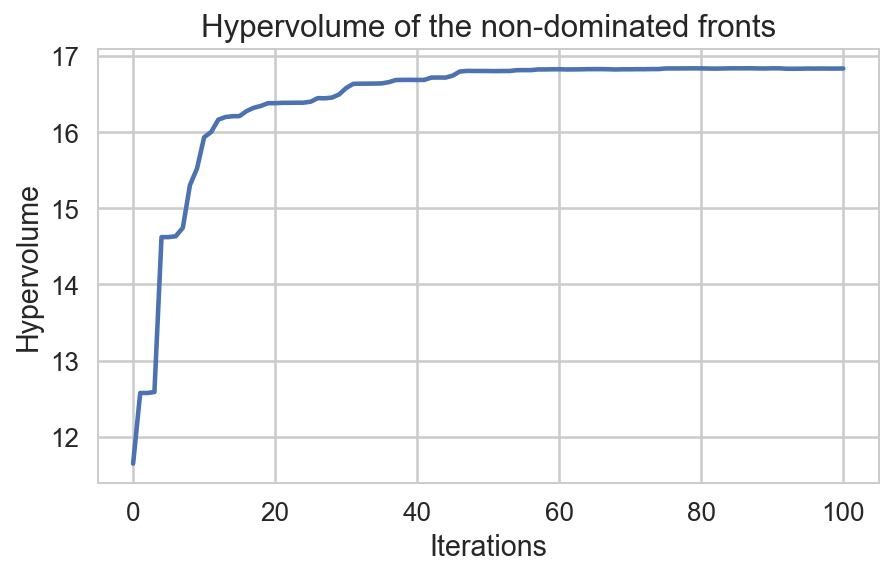

In [69]:
plt.figure(figsize=(7, 4))
plt.plot(hypervols)
plt.title('Hypervolume of the non-dominated fronts')
plt.xlabel('Iterations')
plt.ylabel('Hypervolume');

# Experimentation
### An illustrative simple/sample case

Let's make a relatively simple but very important experiment:

### Question: 
* In our NSGA-II applied to a two-objective DTLZ3 problem: 

<div class='well well-sm'>Is it more important to have a big population and let the algorithm run for a few iterations or is better to have a small population and let the algorithm run for larger number of iterations?
</div>

### Procedure: 
* We must perform an experiment testing different population sizes and maximum number of iterations while keeping the other parameters constant.

### Notation

As usual we need to establish some notation:

* *Multi-objective problem* (or just *problem*): A multi-objective optimization problem, as defined above.
* *MOEA*: An evolutionary computation method used to solve multi-objective problems.
* *Experiment*: a combination of problem and MOEA and a set of values of their parameters.
* *Experiment run*: The result of running an experiment.
* We will use `toolbox` instances to define experiments. 

We start by creating a `toolbox` that will contain the configuration that will be shared across all experiments.

In [70]:
toolbox = base.Toolbox()

In [71]:
BOUND_LOW, BOUND_UP = 0.0, 1.0
NDIM = 30
# the explanation of this... a few lines bellow
def eval_helper(ind):
    return benchmarks.dtlz3(ind, 2)

toolbox.register("evaluate", eval_helper)

In [72]:
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual2Obj, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

toolbox.register("select", tools.selNSGA2)

toolbox.mut_prob = 0.15

We add a `experiment_name` to `toolbox` that we will fill up later on. 
* $n_\mathrm{pop}$ denotes the population size, and 
* $t_\mathrm{max}$ the max. number of iterations.

In [73]:
experiment_name = "$n_\mathrm{{pop}}={0};\ t_\mathrm{{max}}={1}$"

We can now replicate the `toolbox` instance and then modify $n_\mathrm{pop}$ and $t_\mathrm{max}$.

In [74]:
total_evals = 500

In [75]:
pop_sizes = (10, 50, 100)

In [76]:
toolboxes = list([copy.deepcopy(toolbox) for _ in range(len(pop_sizes))])

Now `toolboxes` is a list of copies of the same toolbox. One for each experiment configuration (population size).

...but we still have to set the population sizes in the elements of `toolboxes`.

In [77]:
for pop_size, toolbox in zip(pop_sizes, toolboxes):
    toolbox.pop_size = pop_size
    toolbox.max_gen = total_evals // pop_size
    toolbox.experiment_name = experiment_name.format(toolbox.pop_size, toolbox.max_gen)

In [78]:
for toolbox in toolboxes:
    print(toolbox.experiment_name, toolbox.pop_size, toolbox.max_gen)

$n_\mathrm{pop}=10;\ t_\mathrm{max}=50$ 10 50
$n_\mathrm{pop}=50;\ t_\mathrm{max}=10$ 50 10
$n_\mathrm{pop}=100;\ t_\mathrm{max}=5$ 100 5


## Experiment design

As we are dealing with stochastic methods their results should be reported relying on an statistical analysis.

* A given  experiment (a `toolbox` instance in our case) should be repeated a *sufficient* amount of times. 
* In theory, the more runs the better, but how much in enough? In practice, we could say that about *30* runs is enough.
* The non-dominated fronts produced by each experiment run should be compared to each other. 
* We have seen that a number of *performance indicators*, like the *hypervolume*, *additive* and *multiplicative epsilon indicators*, among others, have been proposed for that task.
* We can use statistical visualizations like [box plots](http://en.wikipedia.org/wiki/Box_plot) or [violin plots](http://en.wikipedia.org/wiki/Violin_plot) to make a visual assessment of the indicator values produced in each run.
* We must apply a set of [statistical hypothesis tests](http://en.wikipedia.org/wiki/Statistical_hypothesis_testing) in order to reach an statistically valid judgment of the results of an algorithms. 

_Note_: I personally like the number [42](http://en.wikipedia.org/wiki/42_%28number%29) as it is the [answer to The Ultimate Question of Life, the Universe, and Everything](http://en.wikipedia.org/wiki/Phrases_from_The_Hitchhiker%27s_Guide_to_the_Galaxy#Answer_to_the_Ultimate_Question_of_Life.2C_the_Universe.2C_and_Everything_.2842.29).

In [79]:
number_of_runs = 42

## Running experiments in parallel 

As we are now solving more demanding problems it would be nice to make our algorithms to run in parallel and profit from modern multi-core CPUs.

* In DEAP it is very simple to parallelize an algorithm (if it has been properly programmed) by providing a parallel `map()` function via the `toolbox`.
* Local parallelization can be achieved using Python's [`multiprocessing`](https://docs.python.org/2/library/multiprocessing.html) or [`concurrent.futures`](https://docs.python.org/3/library/concurrent.futures.html) modules.
* Cluster parallelization can be achieved using IPython Parallel or [SCOOP](http://en.wikipedia.org/wiki/Python_SCOOP_%28software%29).

### Progress feedback

* Another issue with these long experiments has to do being patient.
* A little bit of feedback on the experiment execution would be cool.
* We can use the integer progress bar from [IPython widgets](http://nbviewer.ipython.org/github/jvns/ipython/blob/master/examples/Interactive%20Widgets/Index.ipynb) and report every time an experiment run is finished.

In [80]:
from ipywidgets import IntProgress
from IPython.display import display

### A side-effect of using process-based parallelization

Process-based parallelization based on `multiprocessing` requires that the parameters passed to `map()` be [pickleable](https://docs.python.org/3.4/library/pickle.html).

* The direct consequence is that `lambda` functions can not be directly used. 
* This is will certainly ruin the party to all `lambda` fans out there! *-me included*.
* Hence we need to write some wrapper functions instead.
* But, that wrapper function can take care of filtering out dominated individuals in the results.

In [81]:
def run_algo_wrapper(toolbox):
    result, _ = run_ea(toolbox)
    local_pareto_set = tools.emo.sortLogNondominated(result, len(result), first_front_only=True)
    return local_pareto_set

# All set! Run the experiments...

In [106]:
%%time
import concurrent.futures
#progress_bar = IntProgress(description="000/000", max=len(toolboxes)*number_of_runs)
#display(progress_bar)

results = {toolbox.experiment_name:[] for toolbox in toolboxes}
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Submit all the tasks...
    futures = {executor.submit(run_algo_wrapper, toolbox): toolbox
               for _ in range(number_of_runs)
               for toolbox in toolboxes}
    
    # ...and wait for them to finish.
    for future in concurrent.futures.as_completed(futures):
        tb = futures[future]
        results[tb.experiment_name].append(future.result())
        #progress_bar.value +=1
        #progress_bar.description = "%03d/%03d:" % (progress_bar.value, progress_bar.max)

CPU times: user 78.1 ms, sys: 39.5 ms, total: 118 ms
Wall time: 8.7 s


As running the experiments sometimes takes a long time, it is a good practice to store the results.

In [83]:
# import pickle
# pickle.dump(results, open('nsga_ii_dtlz3-results.pickle', 'wb'))

In case you need it, this file is included in the GitHub repository.

To load the results we would just have to uncomment:

In [84]:
# loaded_results = pickle.load(open('nsga_ii_dtlz3-results.pickle', 'rb'))
# results = loaded_results #  <-- uncomment if needed

`results` is a dictionary, but a pandas `DataFrame` is a more handy container for the results.

In [85]:
res = pd.DataFrame(results)
res = res.reindex_axis([toolbox.experiment_name for toolbox in toolboxes], axis=1)

In [86]:
res.head()

,$n_\mathrm{pop}=10;\ t_\mathrm{max}=50$,$n_\mathrm{pop}=50;\ t_\mathrm{max}=10$,$n_\mathrm{pop}=100;\ t_\mathrm{max}=5$
0,"[[0.9999229551584438, 0.7847301120882898, 0.91...","[[0.9773695651489364, 0.5108269304952506, 0.58...","[[0.9977922088870641, 0.005060997464697681, 0...."
1,"[[0.9968538829670015, 0.08464178817210004, 0.6...","[[0.9962476719086262, 0.18571808766934747, 0.8...","[[0.9998877792430274, 0.4853219390274345, 0.97..."
2,"[[0.9999406891960754, 0.4763069284456909, 0.59...","[[0.9945894224513334, 0.7998925730365924, 0.30...","[[0.9964286463681836, 0.08120428758343223, 0.4..."
3,"[[0.7249949885847278, 0.18684775440220844, 0.4...","[[0.9995413219895755, 0.5127147020908649, 0.30...","[[0.9991628969042616, 0.812186069331288, 0.495..."
4,"[[0.9998783291537854, 0.09544070614711617, 0.3...","[[0.9976227437932261, 0.8714148630385973, 0.47...","[[0.9999332580213418, 0.04782337513663811, 0.2..."


## Calculating performance indicators

* As already mentioned, we need to evaluate the quality of the solutions produced in every execution of the algorithm. 
* We will use the hypervolumne indicator for that.
* Larger hypervolume values are better.
* We already filtered each population a leave only the non-dominated individuals.

In [87]:
def calculate_reference(results, epsilon=0.1):
    alldata = np.concatenate(np.concatenate(results.values))
    obj_vals = [toolbox.evaluate(ind) for ind in alldata]
    return np.max(obj_vals, axis=0) + epsilon

In [88]:
reference = calculate_reference(res)

In [89]:
reference

array([ 3609.85344409,  3490.19777066])

We can now compute the hypervolume of the Pareto-optimal fronts yielded by each algorithm run.

In [90]:
import deap.benchmarks.tools as bt

In [91]:
hypervols = res.applymap(lambda pop: bt.hypervolume(pop, reference))

In [92]:
hypervols.head()

,$n_\mathrm{pop}=10;\ t_\mathrm{max}=50$,$n_\mathrm{pop}=50;\ t_\mathrm{max}=10$,$n_\mathrm{pop}=100;\ t_\mathrm{max}=5$
0,1.127133e+07,1.018610e+07,9.737184e+06
1,1.191137e+07,1.060027e+07,9.126591e+06
2,1.156370e+07,1.010017e+07,9.519725e+06
3,1.048457e+07,9.902162e+06,9.263066e+06
4,1.158846e+07,1.045360e+07,9.480742e+06


# How can we interpret the indicators?

## Option A: *Tabular form*

In [93]:
hypervols.describe()

,$n_\mathrm{pop}=10;\ t_\mathrm{max}=50$,$n_\mathrm{pop}=50;\ t_\mathrm{max}=10$,$n_\mathrm{pop}=100;\ t_\mathrm{max}=5$
count,4.200000e+01,4.200000e+01,4.200000e+01
mean,1.169486e+07,1.021252e+07,9.281511e+06
std,3.796125e+05,3.574814e+05,2.562562e+05
min,1.048457e+07,9.198111e+06,8.694707e+06
25%,1.150384e+07,1.005795e+07,9.165518e+06
50%,1.175490e+07,1.020053e+07,9.276815e+06
75%,1.200654e+07,1.037453e+07,9.482020e+06
max,1.225889e+07,1.129547e+07,9.737184e+06


## Option B: *Visualization*

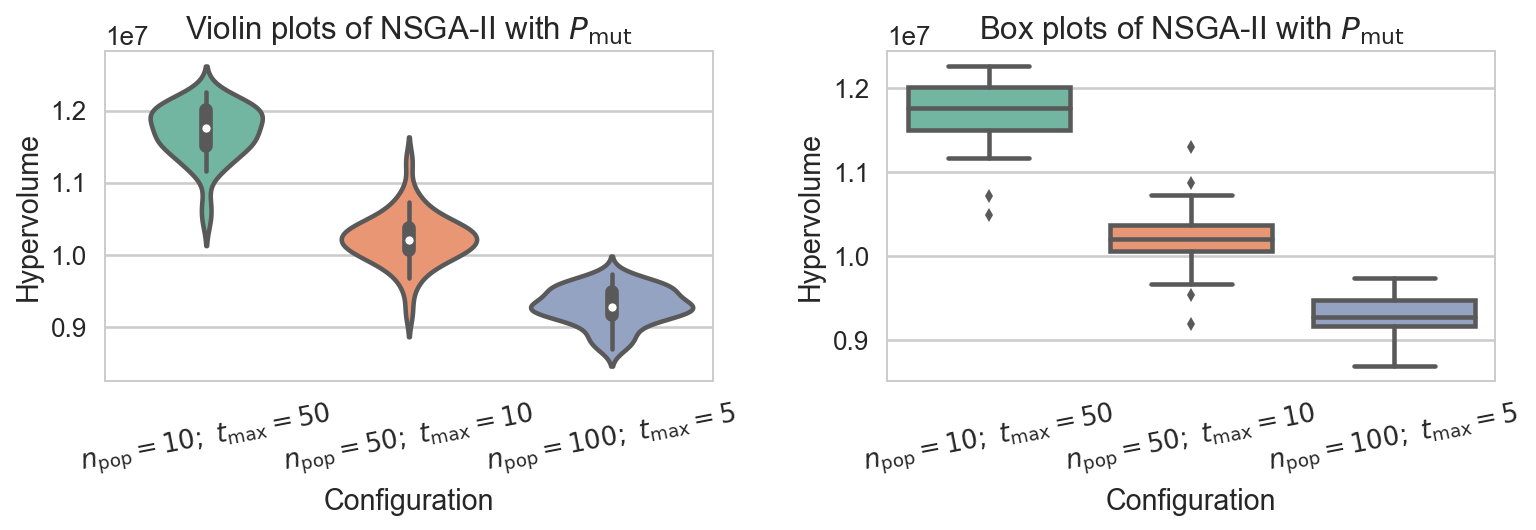

In [94]:
fig = plt.figure(figsize=(11,4))
plt.subplot(121, title='Violin plots of NSGA-II with $P_{\mathrm{mut}}$')
seaborn.violinplot(data=hypervols, palette='Set2')
plt.ylabel('Hypervolume'); plt.xlabel('Configuration'); plt.xticks(rotation=11)
plt.subplot(122, title='Box plots of NSGA-II with $P_{\mathrm{mut}}$')
seaborn.boxplot(data=hypervols, palette='Set2')
plt.ylabel('Hypervolume'); plt.xlabel('Configuration'); plt.xticks(rotation=11)
plt.tight_layout()

## Option C: *Statistical hypothesis test*

* Choosing the correct statistical test is essential to properly report the results.
* [Nonparametric statistics](http://en.wikipedia.org/wiki/Nonparametric_statistics) can lend a helping hand.
* [Parametric statistics](http://en.wikipedia.org/wiki/Parametric_statistics) could be a better choice in some cases. 
* Parametric statistics require that *all* data follow a known distribution (frequently a normal one).
* Some tests -like the [normality test](http://en.wikipedia.org/wiki/Normality_test)- can be apply to verify that data meet the parametric stats requirements.
* In my experience that is very unlikely that all your EMO result meet those characteristics.

We start by writing a function that helps us tabulate the results of the application of an statistical hypothesis test.

In [95]:
import itertools
import scipy.stats as stats

In [96]:
def compute_stat_matrix(data, stat_func, alpha=0.05):
    '''A function that applies `stat_func` to all combinations of columns in `data`.
    Returns a squared matrix with the p-values'''
    p_values = pd.DataFrame(columns=data.columns, index=data.columns)
    for a,b in itertools.combinations(data.columns,2):
        s,p = stat_func(data[a], data[b]) 
        p_values[a].ix[b] = p
        p_values[b].ix[a] = p
    return p_values

The [Kruskal-Wallis H-test](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kruskal.html) tests the null hypothesis that the population median of all of the groups are equal.

* It is a non-parametric version of [ANOVA](http://en.wikipedia.org/wiki/Analysis_of_variance). 
* The test works on 2 or more independent samples, which may have different sizes. 
* Note that rejecting the null hypothesis does not indicate which of the groups differs. 
* Post-hoc comparisons between groups are required to determine which groups are different.

In [97]:
stats.kruskal(*[hypervols[col] for col in hypervols.columns])

KruskalResult(statistic=107.94289999464354, pvalue=3.634938654621329e-24)

We now can assert that the results are not the same but...
* ...which ones are different or similar to the others the others?

In case that the null hypothesis of the Kruskal-Wallis is rejected the Conover–Inman procedure (Conover, 1999, pp. 288-290) can be applied in a pairwise manner in order to determine if the results of one algorithm were significantly better than those of the other.

* Conover, W. J. (1999). *Practical Nonparametric Statistics*. John Wiley & Sons, New York, 3rd edition.

_Note_: If you want to get an extended summary of this method check out my [PhD thesis](http://lmarti.com/). 

In [98]:
def conover_inman_procedure(data, alpha=0.05):
    num_runs = len(data)
    num_algos = len(data.columns)
    N = num_runs*num_algos

    _,p_value = stats.kruskal(*[data[col] for col in data.columns])
    
    ranked =  stats.rankdata(np.concatenate([data[col] for col in data.columns]))
    
    ranksums = []
    for i in range(num_algos):
        ranksums.append(np.sum(ranked[num_runs*i:num_runs*(i+1)]))

    S_sq = (np.sum(ranked**2) - N*((N+1)**2)/4)/(N-1)

    right_side = stats.t.cdf(1-(alpha/2), N-num_algos) * \
                 math.sqrt((S_sq*((N-1-p_value)/(N-1)))*2/num_runs)
    
    res = pd.DataFrame(columns=data.columns, index=data.columns)

    for i,j in itertools.combinations(np.arange(num_algos),2):
        res[res.columns[i]].ix[j] = abs(ranksums[i] - ranksums[j]/num_runs) > right_side
        res[res.columns[j]].ix[i] = abs(ranksums[i] - ranksums[j]/num_runs) > right_side
    return res

In [99]:
conover_inman_procedure(hypervols)

/Users/lm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/Users/lm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


,$n_\mathrm{pop}=10;\ t_\mathrm{max}=50$,$n_\mathrm{pop}=50;\ t_\mathrm{max}=10$,$n_\mathrm{pop}=100;\ t_\mathrm{max}=5$
$n_\mathrm{pop}=10;\ t_\mathrm{max}=50$,NaN,True,True
$n_\mathrm{pop}=50;\ t_\mathrm{max}=10$,True,NaN,True
$n_\mathrm{pop}=100;\ t_\mathrm{max}=5$,True,True,NaN


We now know in what cases the difference is sufficient as to say that one result is better than the other.

Another alternative is the [Friedman test](http://en.wikipedia.org/wiki/Friedman_test).

* Its null hypothesis that repeated measurements of the same individuals have the same distribution. 
* It is often used to test for consistency among measurements obtained in different ways. 
    * For example, if two measurement techniques are used on the same set of individuals, the Friedman test can be used to determine if the two measurement techniques are consistent.

In [100]:
measurements = [list(hypervols[col]) for col in hypervols.columns]
stats.friedmanchisquare(*measurements)

FriedmanchisquareResult(statistic=84.0, pvalue=5.7495222642935676e-19)

[Mann–Whitney U test](http://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) (also called the Mann–Whitney–Wilcoxon (MWW), Wilcoxon rank-sum test (WRS), or Wilcoxon–Mann–Whitney test)
* a nonparametric test,
* null hypothesis: **that two populations are the same** against an alternative hypothesis, especially that a particular population tends to have larger values than the other.

It has greater efficiency than the $t$-test on non-normal distributions, such as a mixture of normal distributions, and it is nearly as efficient as the $t$-test on normal distributions.

In [101]:
raw_p_values=compute_stat_matrix(hypervols, stats.mannwhitneyu)
raw_p_values

/Users/lm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  import sys
/Users/lm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


,$n_\mathrm{pop}=10;\ t_\mathrm{max}=50$,$n_\mathrm{pop}=50;\ t_\mathrm{max}=10$,$n_\mathrm{pop}=100;\ t_\mathrm{max}=5$
$n_\mathrm{pop}=10;\ t_\mathrm{max}=50$,NaN,4.22282e-15,1.56072e-15
$n_\mathrm{pop}=50;\ t_\mathrm{max}=10$,4.22282e-15,NaN,2.09512e-14
$n_\mathrm{pop}=100;\ t_\mathrm{max}=5$,1.56072e-15,2.09512e-14,NaN


The [familywise error rate](http://en.wikipedia.org/wiki/Familywise_error_rate) (FWER) is the probability of making one or more false discoveries, or [type I errors](http://en.wikipedia.org/wiki/Type_I_and_type_II_errors), among all the hypotheses when performing multiple hypotheses tests.

_Example_: When performing a test, there is a $\alpha$ chance of making a type I error. If we make $m$ tests, then the probability of making one type I error is $m\alpha$. Therefore, if an $\alpha=0.05$ is used and 5 pairwise comparisons are made, we will have a $5\times0.05 = 0.25$ chance of making a type I error.

* FWER procedures (such as the [Bonferroni correction](http://en.wikipedia.org/wiki/Bonferroni_correction)) exert a more stringent control over false discovery compared to False discovery rate controlling procedures. 
* FWER controlling seek to reduce the probability of even one false discovery, as opposed to the expected proportion of false discoveries. 
* Thus, FDR procedures have greater power at the cost of increased rates of type I errors, i.e., rejecting the null hypothesis of no effect when it should be accepted.

One of these corrections is the [Šidák correction](http://en.wikipedia.org/wiki/%C5%A0id%C3%A1k_correction) as it is less conservative than the [Bonferroni correction](http://en.wikipedia.org/wiki/Bonferroni_correction):
$$\alpha_{SID} = 1-(1-\alpha)^\frac{1}{m},$$
where $m$ is the number of tests.

* In our case $m$ is the number of combinations of algorithm configurations taken two at a time,

$$
m = {\mathtt{number\_of\_experiments} \choose 2}.
$$

* There are other corrections that can be used.

In [102]:
from scipy.misc import comb

In [103]:
alpha=0.05
alpha_sid = 1 - (1-alpha)**(1/comb(len(hypervols.columns), 2))
alpha_sid

0.016952427508441503

Let's apply the corrected alpha to `raw_p_values`. If we have a cell with a `True` value that means that those two results are the same.

In [104]:
raw_p_values.applymap(lambda value: value <= alpha_sid)

,$n_\mathrm{pop}=10;\ t_\mathrm{max}=50$,$n_\mathrm{pop}=50;\ t_\mathrm{max}=10$,$n_\mathrm{pop}=100;\ t_\mathrm{max}=5$
$n_\mathrm{pop}=10;\ t_\mathrm{max}=50$,False,True,True
$n_\mathrm{pop}=50;\ t_\mathrm{max}=10$,True,False,True
$n_\mathrm{pop}=100;\ t_\mathrm{max}=5$,True,True,False


### Further reading

* Cohen, P. R. (1995). _Empirical Methods for Artificial Intelligence_ (Vol. 139). Cambridge: MIT press. [link](http://mitpress.mit.edu/books/empirical-methods-artificial-intelligence)
* Bartz-Beielstein, Thomas (2006). _Experimental Research in Evolutionary Computation: The New Experimentalism_. Springer [link](http://link.springer.com/book/10.1007%2F3-540-32027-X)
* García, S., & Herrera, F. (2008). _An Extension on “Statistical Comparisons of Classifiers over Multiple Data Sets” for all Pairwise Comparisons_. Journal of Machine Learning Research, 9, 2677–2694. [pdf](http://www.jmlr.org/papers/v9/garcia08a.html)

# Recommended reading

<br/>
<div class="container-fluid">
  <div class="row">
      <div class="col-md-1"></div>
      <div class="col-md-5">
              <img src='https://images.springer.com/sgw/books/medium/9783540889076.jpg'/><br/>
              Branke, J., Deb, K., Miettinen, K., Slowiński, R. (Eds.) (2008) <br/><b>Multiobjective Optimization: Interactive and Evolutionary Approaches</b>.<br/> Springer. <br/>doi: 10.1007/978-3-540-88908-3.
      </div>
      <div class="col-md-5">
              <img src='https://images.springer.com/sgw/books/medium/9780387332543.jpg'/><br/>
              Coello Coello, Carlos, Lamont, Gary B., van Veldhuizen, David A. (2007) <br/> <b>Evolutionary Algorithms for Solving Multi-Objective Problems</b>.<br/>Springer. <br/>doi: 10.1007/978-0-387-36797-2.
      </div>
      <div class="col-md-1"></div>
  </div>
</div>

<div align='center'>
<h2>Obrigado! ¡Gracias! Merci beaucoup! Thank you!</h2><br/>
lmarti@ic.uff.br - http://lmarti.com <br/>
¿Perguntas?
</div>

In [105]:
# this code is here for cosmetic reasons
from IPython.core.display import HTML
from urllib.request import urlopen
HTML(urlopen('https://raw.githubusercontent.com/lmarti/jupyter_custom/master/custom.include').read().decode('utf-8'))